In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import h5py
import scipy.signal as ss
import torch
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
from matplotlib import cm, colors
from matplotlib.ticker import FormatStrFormatter
from fnn.distributions import *
from fnn.notebook.utils import *
import fnn.models as models
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.evaluation import *
import json

In [6]:
def spike_count(time_bin, each_timing):
    compare = (np.expand_dims(each_timing, -1) > time_bin)
    compare_next = np.zeros(compare.shape)
    compare_next[:, :-1] = compare[:, 1:]
    compare_next[:, -1] = False
    spikes = (compare != compare_next).sum(0)
    return spikes

def time_bin_from_stim(stim_time):
    stim_time = stim_time - stim_time[0]
    stim_time_int = np.append(np.diff(stim_time), 0.03)
    time_bin = np.zeros(stim_time.shape[0]*3)
    time_bin[0::3] = stim_time
    time_bin[1::3] = stim_time + stim_time_int/3
    time_bin[2::3] = stim_time + stim_time_int*2/3
    return time_bin

with open('/home/xhding/tem_stim/16-05-31_expt.json', 'r') as f:
    expt = json.load(f)
g = h5py.File('/home/xhding/tem_stim/16-05-31/naturalscene.h5', 'r')

h = h5py.File('/home/xhding/tem_stim/photodiode.h5', 'r')
pd = np.array(h['photodiode']['16-05-31'])
peaks = ss.find_peaks(-pd, height=200, distance=90)[0]

test_indices = []
for i, stim in enumerate(expt['stim']):
    if stim['function'] == 'naturalscene' and stim['params']['seed'] == 90:
        test_indices.append(i)
cells = [2, 3, 14, 16, 18, 20, 25, 27]

num_trials = len(test_indices)
#num_bins = len(expt['stim'][test_indices[0]]['timestamps']) * 3
num_bins = np.array(g['test/time']).shape[0]
num_cells = len(cells)
repeats = np.zeros((num_trials, num_cells, num_bins))

for trial, idx in enumerate(test_indices):
    stim_time = np.array(expt['stim'][idx]['timestamps']).squeeze()
    #time_bin = time_bin_from_stim(stim_time)
    time_bin = np.array(g['test/time'])
    each_start = peaks[3*idx] / 20000.
    each_end = each_start + expt['stim'][idx]['timestamps'][-1][0] - expt['stim'][idx]['timestamps'][0][0]
    for cell_idx, cell in enumerate(cells):
        timing = np.array(g['spikes']['cell{:02}'.format(cell+1)])
        each_timing = timing[(timing>each_start) * (timing<each_end)] - each_start
        repeats[trial, cell_idx, :time_bin.shape[0]] = spike_count(time_bin, each_timing)

In [7]:
with h5py.File('/home/xhding/tem_stim/16-05-31/naturalscene_test.h5', 'w') as f:
    f.create_dataset('test/stimulus', data=g['test/stimulus'])
    f.create_dataset('test/response/binned', data=g['test/response/binned'])
    f.create_dataset('test/response/firing_rate_10ms', data=g['test/response/firing_rate_10ms'])
    f.create_dataset('test/repeats/binned', data=repeats)

In [58]:
noise_cor = noise_corr2(np.swapaxes(repeats, 1, 2))
stim_cor = stim_corr2(np.swapaxes(repeats, 1, 2))
num_cells = 9
diagonal_idxs = list(range(0, num_cells*num_cells, num_cells+1))
trial_cor = stim_cor.flatten()[diagonal_idxs]
stim_cor = np.delete(stim_cor.flatten(), diagonal_idxs)
noise_cor = np.delete(noise_cor.flatten(), diagonal_idxs)

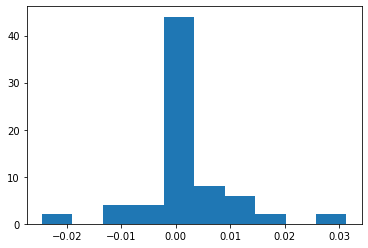

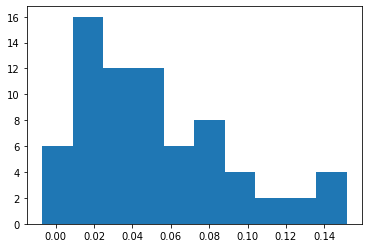

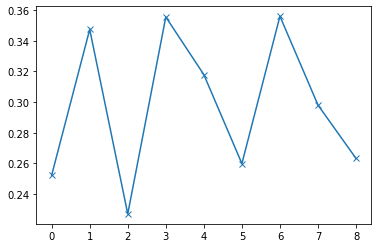

In [59]:
plt.hist(noise_cor)
plt.show()
plt.hist(stim_cor)
plt.show()
plt.plot(trial_cor, 'x-')
plt.show()

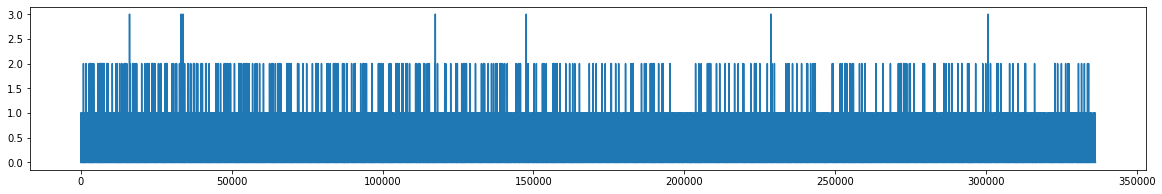

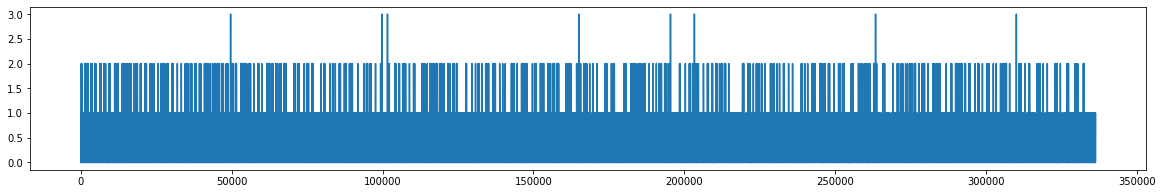

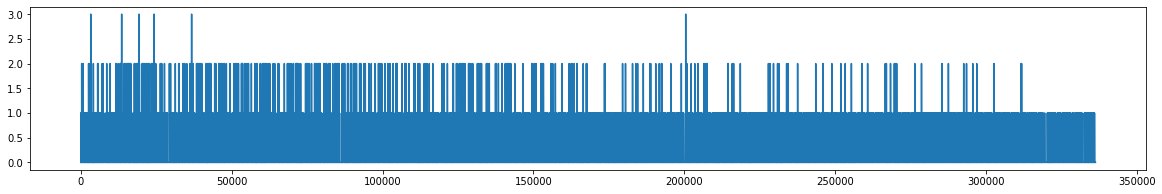

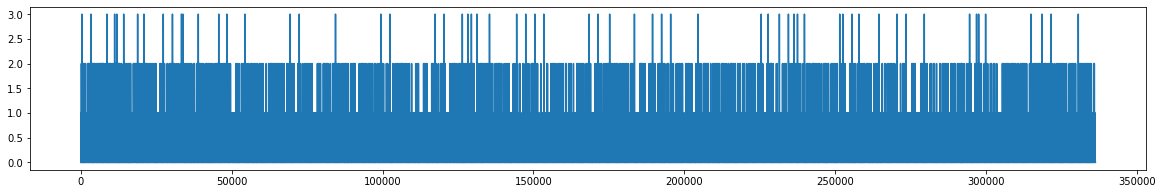

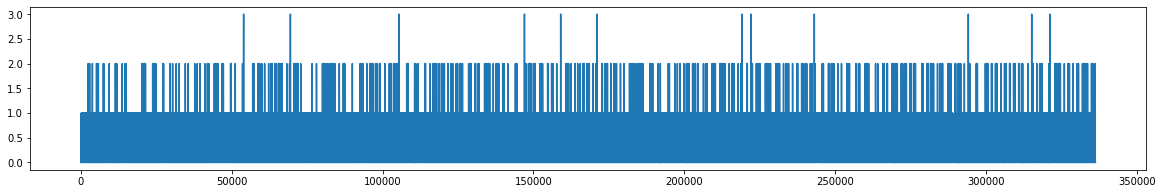

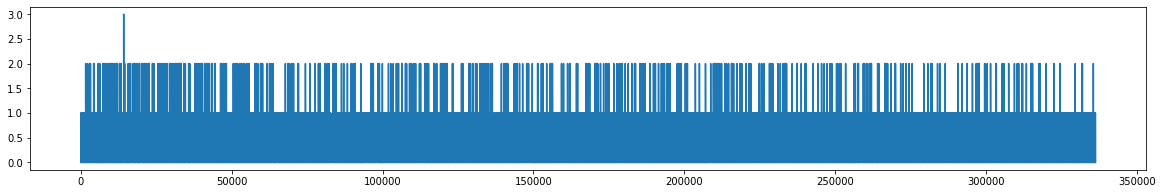

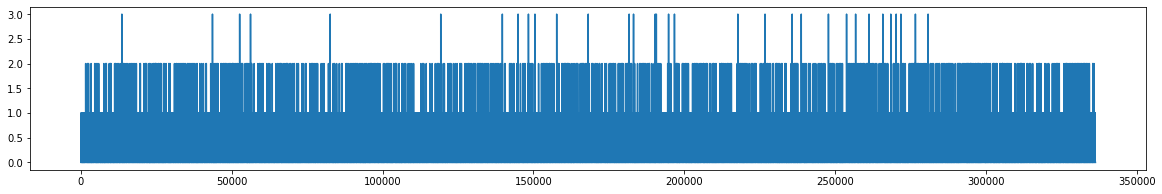

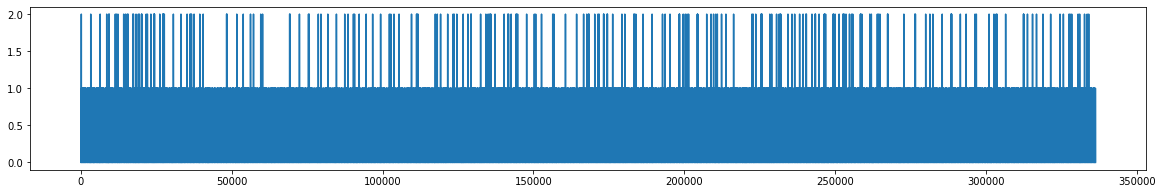

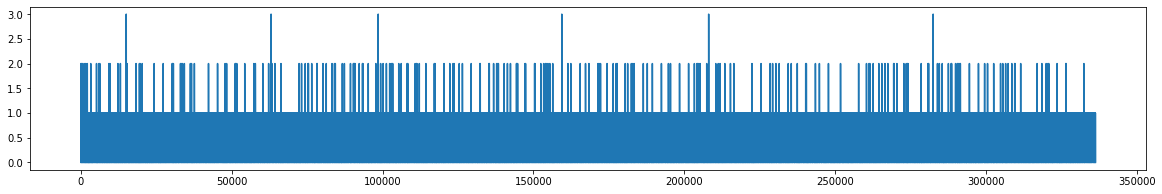

In [62]:
repeats_concat = np.concatenate(repeats, axis=1)
for cell in range(repeats_concat.shape[0]):
    plt.figure(figsize=(20,3))
    plt.plot(repeats_concat[cell])
    plt.show()

In [4]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_16-05-31')
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_-4.19_pearson_0.5765.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_015_loss_-3.61_pearson_0.5341.pth'
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_pearson_0.9647.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_010_pearson_0.8387.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 8, device)

In [403]:
test_pc

0.9647283072111106

In [37]:
pearsonr_eval_cell(model, test_data, 8, device)

[0.519861109398172,
 0.6288410908930591,
 0.5437620872358504,
 0.6527452556230805,
 0.5273377767156159,
 0.6768374396911624,
 0.5641064417948269,
 0.6967488309919916]

In [8]:
for cell in range(repeats.shape[1]):
    print(cell, (repeats[:,cell] >= repeats.max((0,2))[cell]).sum(), (repeats[:,cell] >= repeats.max((0,2))[cell]-1).sum(), (repeats[:,cell] >= repeats.max((0,2))[cell]-2).sum(), repeats.max((0,2))[cell])

0 7 387 9336 3.0
1 8 498 9975 3.0
2 65 1201 14865 3.0
3 12 472 7828 3.0
4 1 488 13004 3.0
5 32 953 15306 3.0
6 229 9574 336336 2.0
7 6 240 14134 3.0


In [5]:
file_path = '/home/xhding/tem_stim/16-05-31/naturalscene_test.h5'
cells = list(range(8))
t_list = [3, 3, 4, 4, 3, 4, 3, 3]
recording = recording_stats(file_path, cells)
recording_cut = recording_stats(file_path, cells, truncate=True, t_list=t_list)
single_trial_bin = recording.single_trial_bin
single_trial_bin_cut = recording_cut.single_trial_bin

In [10]:
for cell in range(8):
    dist = distribution(t_list[cell])
    try:
        print(cell, dist.optimize_k('binomial_scale', single_trial_bin_cut, cell))
    except:
        print(cell)

0 1.421875
1 1.6240234375
2 1.6591796875
3 1.755859375
4 1.5361328125
5 1.9931640625
6 1.896484375
7 2.037109375


In [11]:
optimum_para = {}
optimum_para['binomial'] = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
stats = variance_mean(recording, t_list, optimum_para)

0


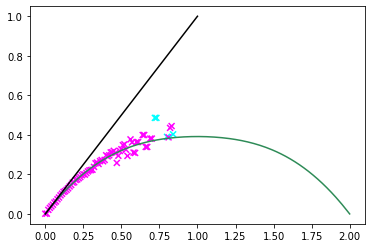

1


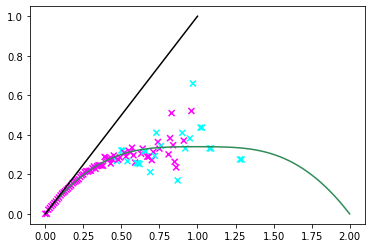

2


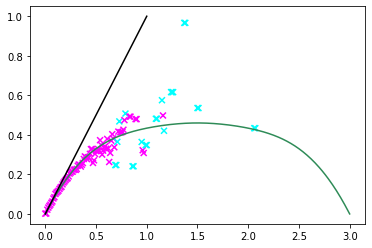

3


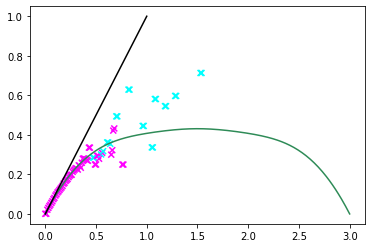

4


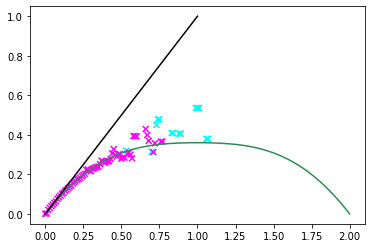

5


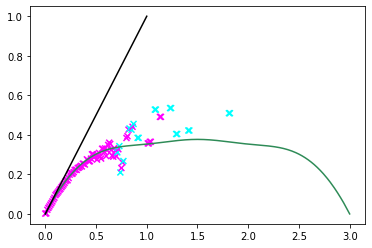

6


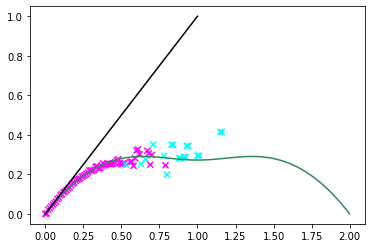

7


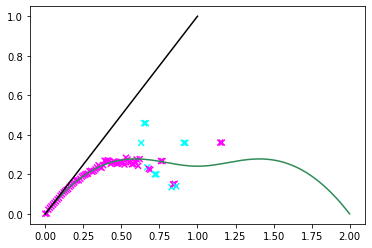

In [12]:
for cell in range(8):
    print(cell)
    plt.scatter(stats[cell]['means'], stats[cell]['variances'], c=stats[cell]['weights'], marker='x', cmap='cool', vmax=150, label='empirical')
    plt.plot(stats[cell]['means_dis'], stats[cell]['vars_dis'], '-', color='#2E8B57', label='binomial')
    plt.plot([0, 1], [0, 1], 'k')
    plt.show()

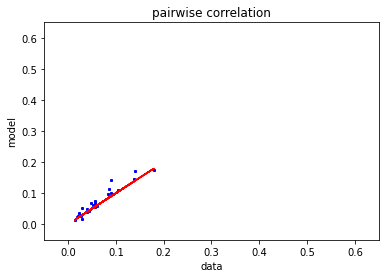

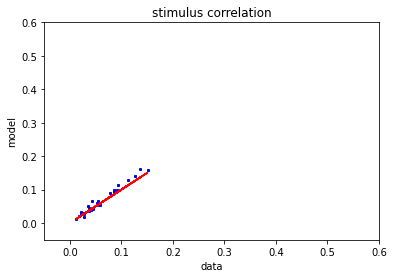

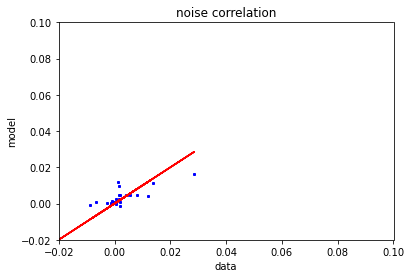

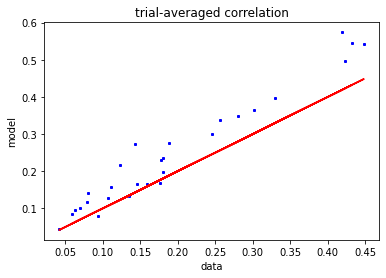

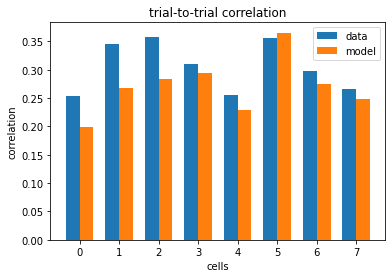

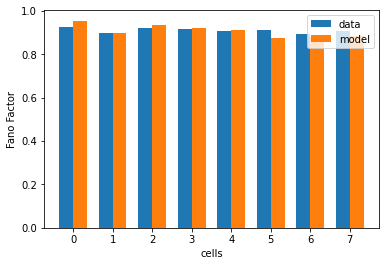

0.0036536687616392596


In [404]:
binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
t_list = [3, 3, 4, 4, 3, 4, 3, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 112, [0., 0., 0.1, 0.], seed=None)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.3, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=None, thre=1)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

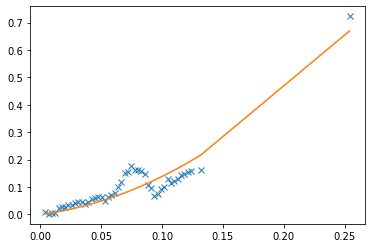

In [401]:
def poly(x,c,d):
        return c*x**2+d*x
#def poly(x, a, b, c):
#    return a*x**b + c*x
    
cell = 0
means = []
rates = []
sigmas = []
for rate in np.linspace(0.4, pred_single_trial_pre.mean(0)[:, cell].max(), 100):
    mean, var, _, w = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate, intv=0.6)
    if var > 0:
        sigmas.append(np.sqrt(var/(w-1)))
        means.append(mean)
        rates.append(rate/100)
sigmas = np.array(sigmas)[~np.isnan(means)]
rates = np.array(rates)[~np.isnan(means)]
means = np.array(means)[~np.isnan(means)]

max_idx = np.where(means >= 0.8*means.max())[0][-1]
min_idx = np.where(rates == rates.min())[0][0]
slope = (means[max_idx] -  means[min_idx]) / (rates[max_idx] -  rates[min_idx])
means_res = means - (rates - rates[min_idx]) * slope - means[min_idx]
valid_idx = np.where(np.abs(means_res/means[max_idx]) < 0.3)

rates = rates[valid_idx]
means = means[valid_idx]
sigmas = sigmas[valid_idx]

para = curve_fit(poly, rates, means)[0]

plt.plot(rates, means, 'x')
plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])

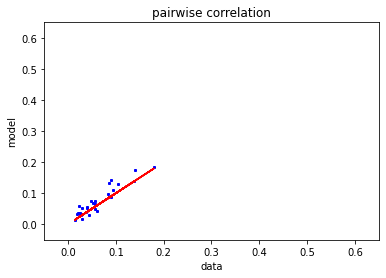

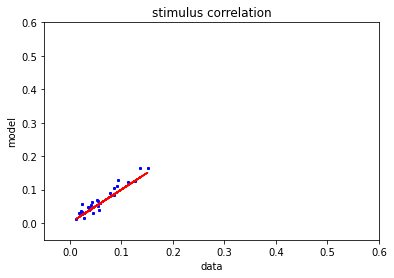

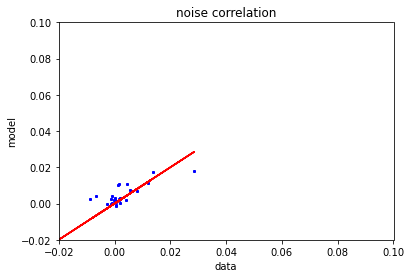

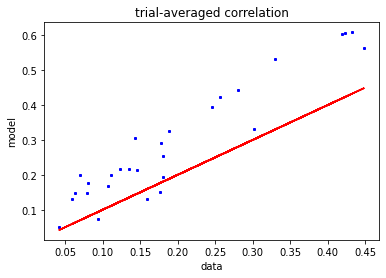

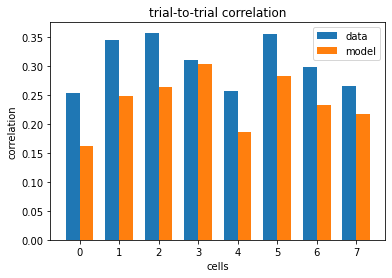

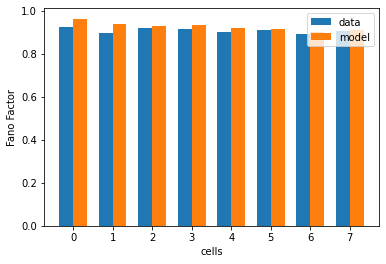

0.005134477134102849


In [369]:
binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
t_list = [3, 3, 4, 4, 3, 4, 3, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 112, [0., 0., 0.1, 0.], seed=None)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.3, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=None, thre=1)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

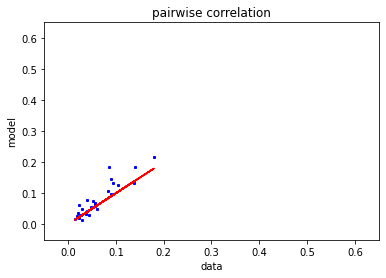

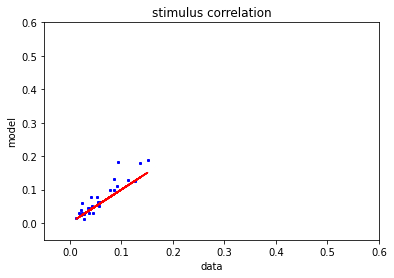

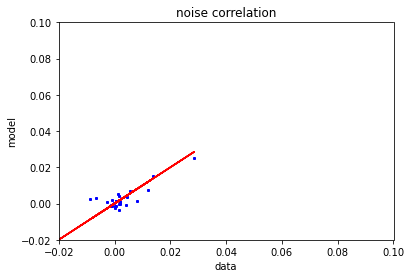

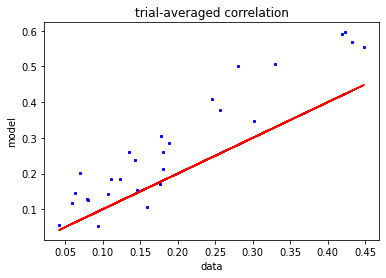

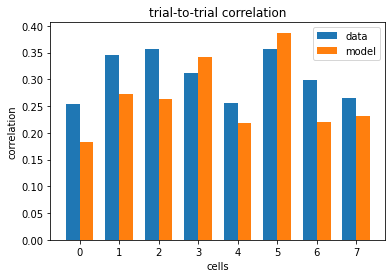

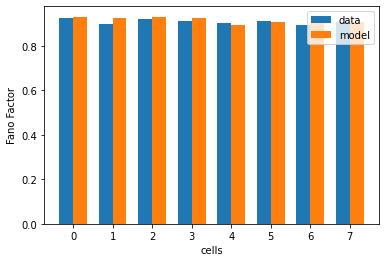

0.004095543590934597


In [371]:
binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
t_list = [3, 3, 4, 4, 3, 4, 3, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 112, [0.9, 0., 0., 0.], seed=None)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.3, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=None, thre=1)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

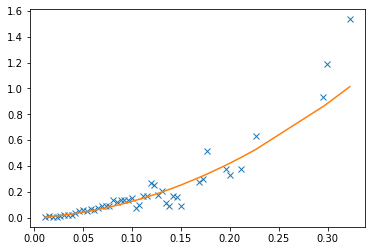

In [300]:
def poly(x,c,d):
        return c*x**2+d*x
#def poly(x, a, b, c):
#    return a*x**b + c*x
    
cell = 3
means = []
rates = []
sigmas = []
for rate in np.linspace(0.4, pred_single_trial_pre.mean(0)[:, cell].max(), 100):
    mean, var, _, w = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate, intv=0.3)
    if var > 0:
        sigmas.append(np.sqrt(var/(w-1)))
        means.append(mean)
        rates.append(rate/100)
sigmas = np.array(sigmas)[~np.isnan(means)]
rates = np.array(rates)[~np.isnan(means)]
means = np.array(means)[~np.isnan(means)]

max_idx = np.where(means >= 0.8*means.max())[0][-1]
min_idx = np.where(rates == rates.min())[0][0]
slope = (means[max_idx] -  means[min_idx]) / (rates[max_idx] -  rates[min_idx])
means_res = means - (rates - rates[min_idx]) * slope - means[min_idx]
valid_idx = np.where(np.abs(means_res/means[max_idx]) < 0.4)

rates = rates[valid_idx]
means = means[valid_idx]
sigmas = sigmas[valid_idx]

para = curve_fit(poly, rates, means, sigma=sigmas)[0]

plt.plot(rates, means, 'x')
plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])

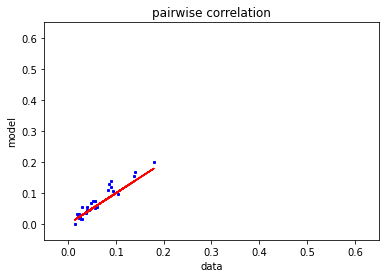

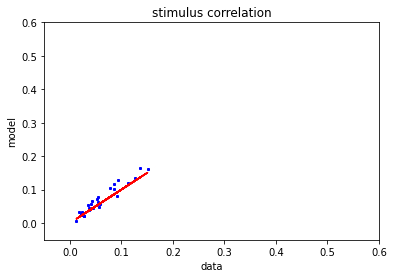

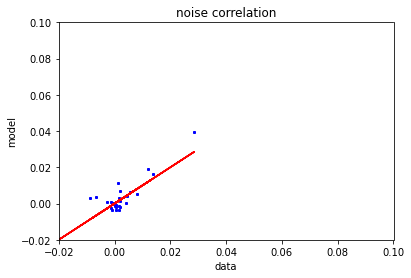

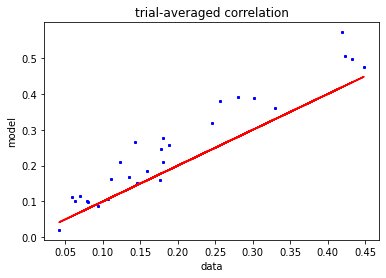

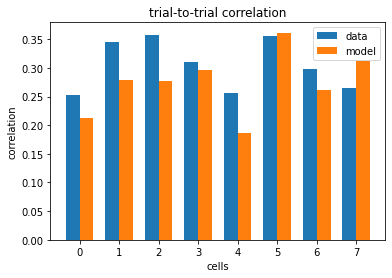

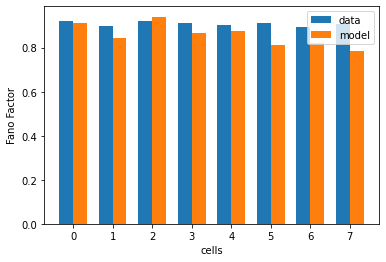

0.005066809734990317


In [164]:
binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
t_list = [3, 3, 4, 4, 3, 4, 3, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 112, [1.5, 0., 0., 0.], seed=None)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=None, thre=4)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

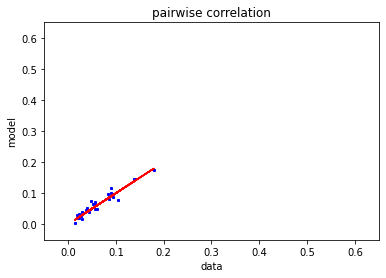

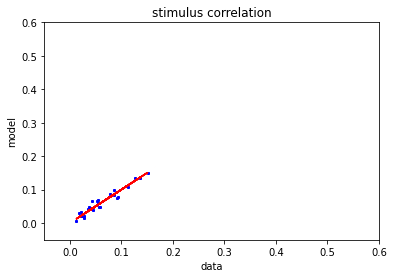

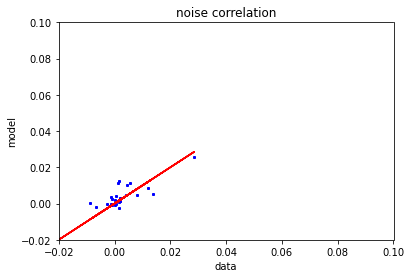

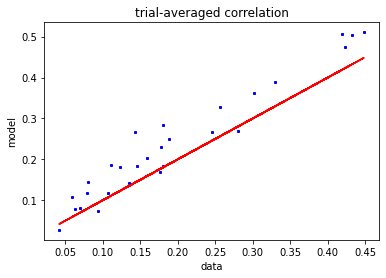

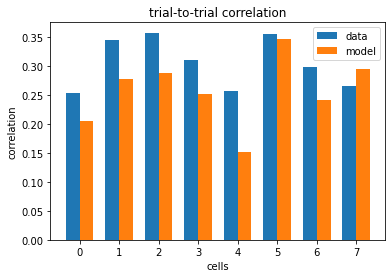

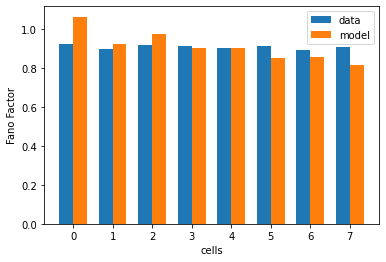

0.0033355681148987196


In [119]:
binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
t_list = [3, 3, 4, 4, 3, 4, 3, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 112, [0., 0., 0.15, 0.], seed=None)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=None, thre=3)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

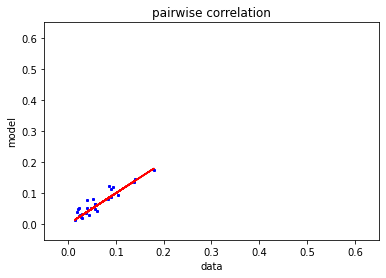

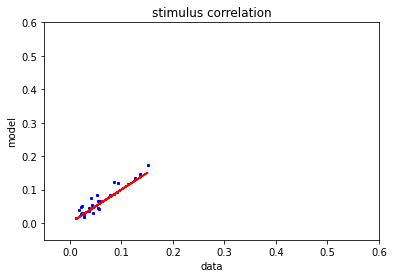

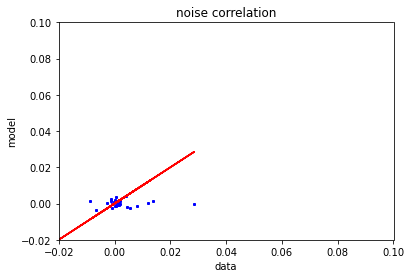

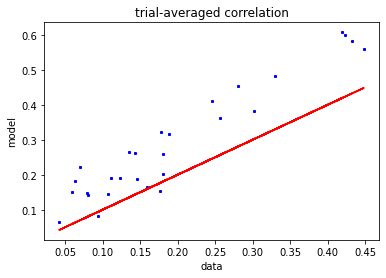

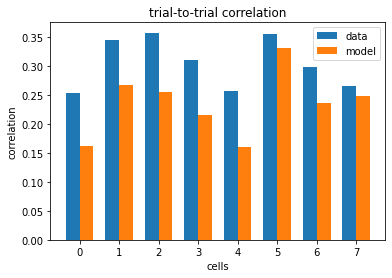

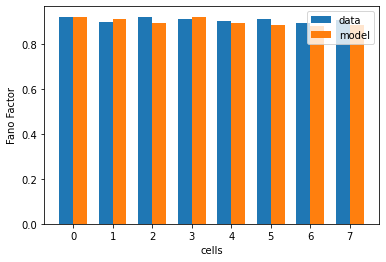

0.0037952228640135074


In [380]:
binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
t_list = [3, 3, 4, 4, 3, 4, 3, 3]
poly_paras = poly_para_fit(recording, np.tile(pred, (112, 1, 1)), pred, thre=2, threshold=0.5, intv=0.5, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(np.tile(pred, (112, 1, 1)), binomial_para, t_list, poly_paras, pred, n_repeats=10, seed=None, thre=2)

min_error = 10
for i in range(10):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

0.2551980781555176 25.519808


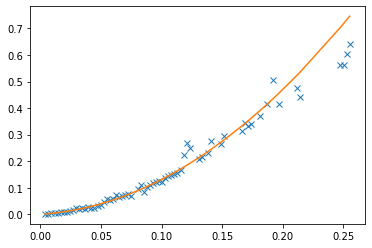

In [378]:
def poly(x,c,d):
        return c*x**2+d*x
    
cell = 0
means = []
rates = []
sigmas = []
for rate in np.linspace(0.4, pred[:, cell].max(), 100):
    mean, var, _, w = recording.stats_rate(pred, cell=cell, rate=rate, intv=0.3)
    if var > 0:
        sigmas.append(np.sqrt(var/(w-1)))
        means.append(mean)
        rates.append(rate/100)
sigmas = np.array(sigmas)[~np.isnan(means)]
rates = np.array(rates)[~np.isnan(means)]
means = np.array(means)[~np.isnan(means)]

max_idx = np.where(means >= 0.8 * means.max())[0][-1]
min_idx = np.where(rates == rates.min())[0][0]
slope = (means[max_idx] -  means[min_idx]) / (rates[max_idx] -  rates[min_idx])
means_res = means - (rates - rates[min_idx]) * slope - means[min_idx]
valid_idx = np.where(np.abs(means_res/means[max_idx]) < 0.2)

rates = rates[valid_idx]
means = means[valid_idx]
sigmas = sigmas[valid_idx]

para = curve_fit(poly, rates, means, sigma=sigmas)[0]

plt.plot(rates, means, 'x')
plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])
print(rates.max(), pred[:, cell].max())

0.031174543957196675
0.026636865398255882


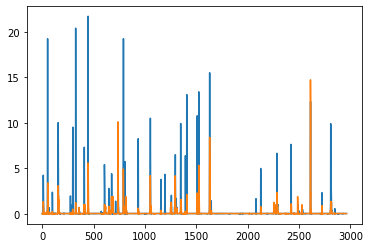

In [367]:
cell = 0
num_trials = 112
contribution1 = []
std1 = []
for i in range(num_trials):
    for j in range(i+1, num_trials):
        a = single_trial_bin[i,:,cell]
        b = single_trial_bin[j,:,cell]
        c = (a - a.mean()) * (b - b.mean()) / a.std() / b.std()
        contribution1.append(c)
        std1.append(a)
contribution1 = np.stack(contribution1).mean(0)
print(np.array(std1).mean())

std2 = []
contribution2 = []
for i in range(num_trials):
    for j in range(i+1, num_trials):
        a = pred_single_trial_try[i,:,cell]
        b = pred_single_trial_try[j,:,cell]
        c = (a - a.mean()) * (b - b.mean()) / a.std() / b.std()
        contribution2.append(c)
        std2.append(a)
contribution2 = np.stack(contribution2).mean(0)
print(np.array(std2).mean())
plt.plot(contribution1)
plt.plot(contribution2)

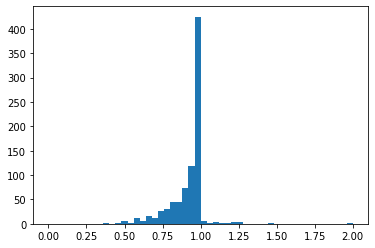

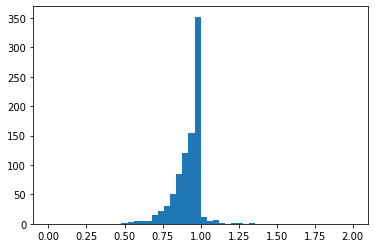

In [305]:
cell = 0
plt.hist((np.var(single_trial_bin[:,:,cell], axis=0)/np.mean(single_trial_bin[:,:,cell], axis=0)), bins=50, range=(0,2))
plt.show()
plt.hist((np.var(pred_single_trial_try[:,:,cell], axis=0)/np.mean(pred_single_trial_try[:,:,cell], axis=0)), bins=50, range=(0,2))
plt.show()

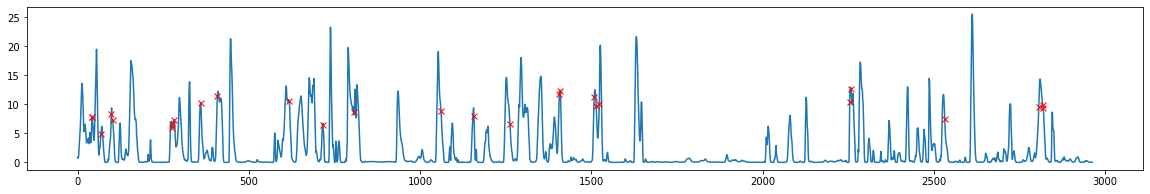

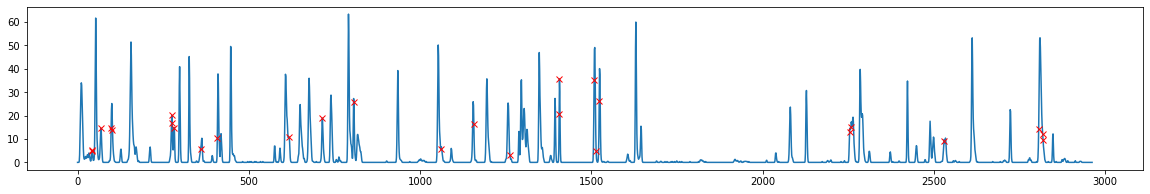

In [153]:
cell = 0
a = (np.var(pred_single_trial_try[:,:,cell], axis=0)/np.mean(pred_single_trial_try[:,:,cell], axis=0))
b = np.where((a>1))[0]
plt.figure(figsize=(20,3))
plt.plot(pred[:, cell])
plt.plot(b, pred[b, cell], 'rx')
plt.show()
plt.figure(figsize=(20,3))
plt.plot(targ[:, cell])
plt.plot(b, targ[b, cell], 'rx')
plt.show()

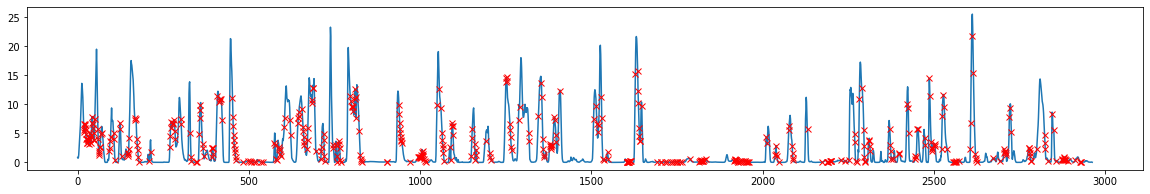

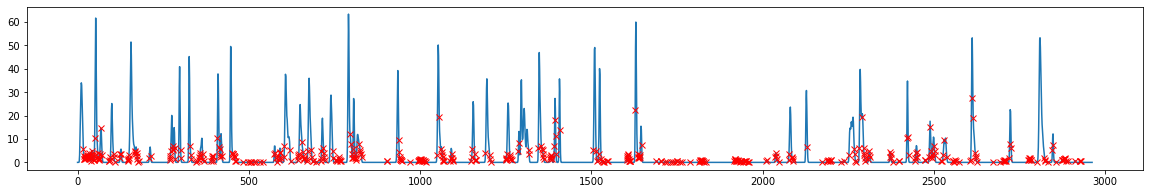

In [154]:
cell = 0
a = (np.var(single_trial_bin[:,:,cell], axis=0)/np.mean(single_trial_bin[:,:,cell], axis=0))
b = np.where((a<=1)*(a>0.95))[0]
plt.figure(figsize=(20,3))
plt.plot(pred[:, cell])
plt.plot(b, pred[b, cell], 'rx')
plt.show()
plt.figure(figsize=(20,3))
plt.plot(targ[:, cell])
plt.plot(b, targ[b, cell], 'rx')
plt.show()

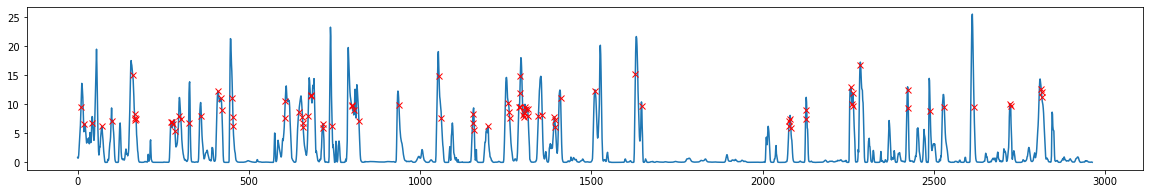

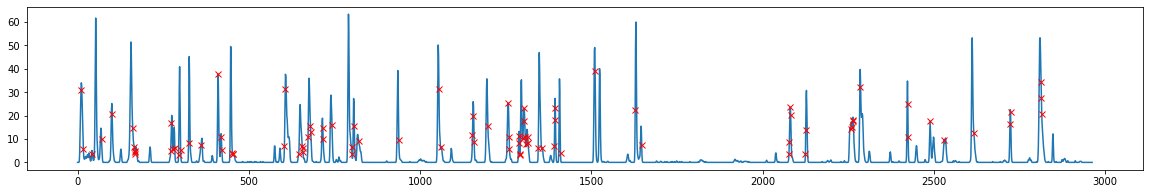

In [157]:
cell = 0
a = (np.var(pred_single_trial_try[:,:,cell], axis=0)/np.mean(pred_single_trial_try[:,:,cell], axis=0))
b = np.where((a>0.88)*(a<0.92))[0]
plt.figure(figsize=(20,3))
plt.plot(pred[:, cell])
plt.plot(b, pred[b, cell], 'rx')
plt.show()
plt.figure(figsize=(20,3))
plt.plot(targ[:, cell])
plt.plot(b, targ[b, cell], 'rx')
plt.show()

In [446]:
g2_errors = []
g1_errors = []
g0_errors = []

t_list = [3, 3, 4, 4, 3, 4, 3, 3]

for g2 in np.linspace(0., 0.2, 21):
    binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 112, [0, 0, g2, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.3, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=1)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, ignore_idxs=[39, 60])
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g2_errors.append((g2, min_error_stim, min_error))

for g1 in np.linspace(0., 0.2, 21):
    binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 112, [0, g1, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.3, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=1)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, ignore_idxs=[39, 60])
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g1_errors.append((g1, min_error_stim, min_error))

for g0 in np.linspace(0, 2, 21):
    binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 112, [g0, 0, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.3, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=1)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, ignore_idxs=[39, 60])
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g0_errors.append((g0, min_error_stim, min_error))

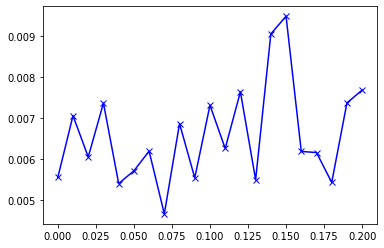

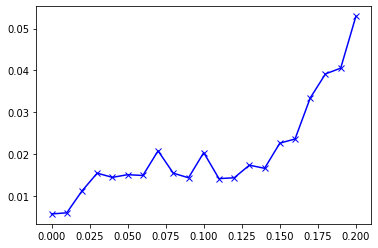

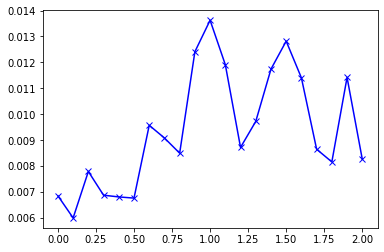

In [447]:
errors = np.convolve(np.array(g2_errors)[:, 1], np.ones(1), mode='same')
plt.plot(np.array(g2_errors)[:, 0], np.array(g2_errors)[:, 1], 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 1], np.ones(1), mode='same')
plt.plot(np.array(g1_errors)[:, 0], np.array(g1_errors)[:, 1], 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 1], np.ones(1), mode='same')
plt.plot(np.array(g0_errors)[:, 0], np.array(g0_errors)[:, 1], 'bx-')
plt.show()

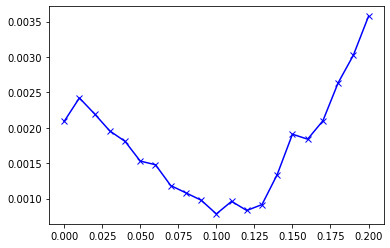

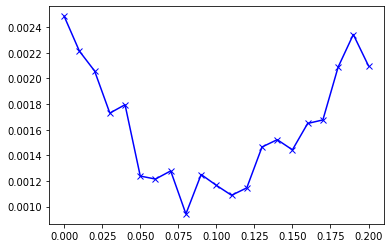

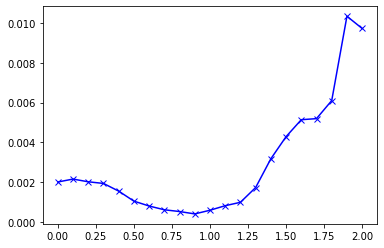

In [448]:
errors = np.convolve(np.array(g2_errors)[:, 1], np.ones(1), mode='same')
plt.plot(np.array(g2_errors)[:, 0], np.array(g2_errors)[:, 2], 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 1], np.ones(1), mode='same')
plt.plot(np.array(g1_errors)[:, 0], np.array(g1_errors)[:, 2], 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 1], np.ones(1), mode='same')
plt.plot(np.array(g0_errors)[:, 0], np.array(g0_errors)[:, 2], 'bx-')
plt.show()

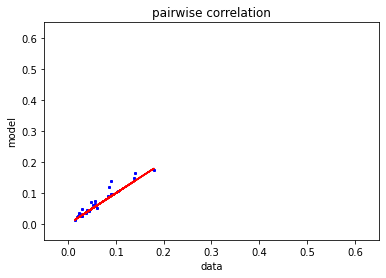

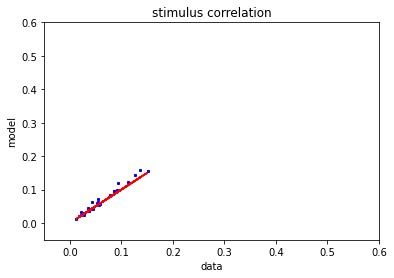

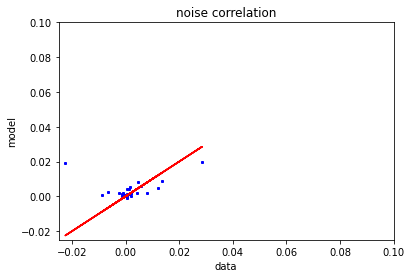

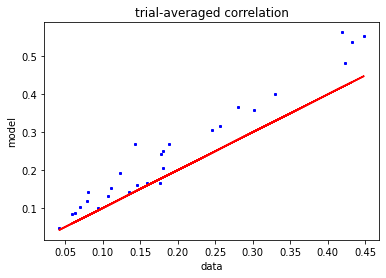

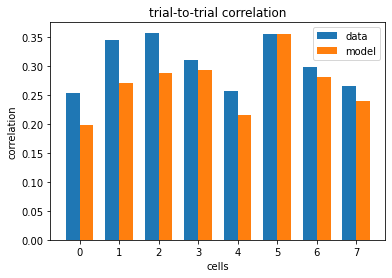

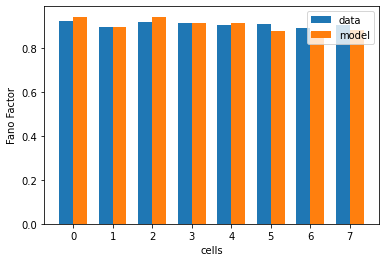

0.0009257777214102807


In [445]:
binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
t_list = [3, 3, 4, 4, 3, 4, 3, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 112, [0., 0., 0.1, 0.], seed=None)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.3, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=None, thre=1)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial, [39, 60])
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

In [453]:
single_trial_bin.sum(), pred_single_trial_try.sum()

(96593.0, 95218)

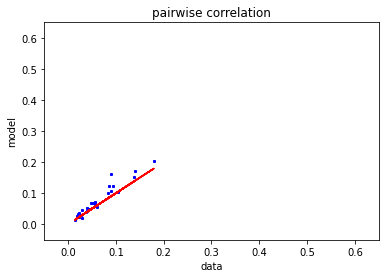

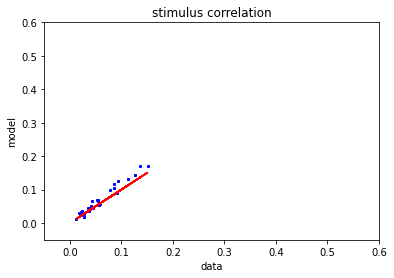

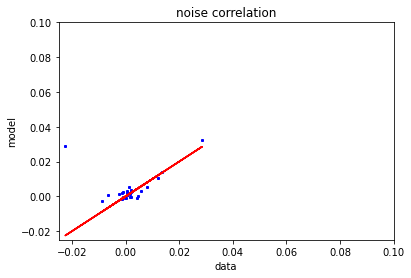

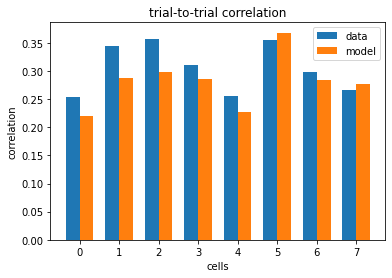

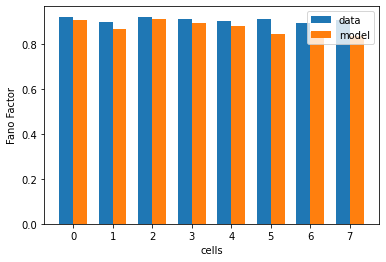

0.0005026495879428787
96593.0 98009


In [471]:
binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
t_list = [3, 3, 4, 4, 3, 4, 3, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 112, [1., 0., 0., 0.], seed=None)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=2, threshold=0.4, intv=0.3, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=None, thre=2)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial, [39, 60])
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)
print(single_trial_bin.sum(), pred_single_trial_try.sum())

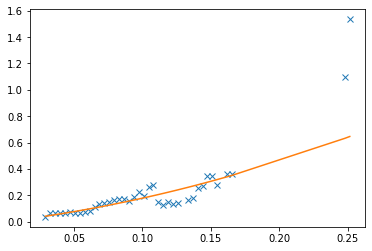

In [469]:
def poly(x,c,d):
        return c*x**2+d*x
    
cell = 3
means = []
rates = []
sigmas = []
thre = 3
pred_single_trial[:, pred<thre] = 0
for rate in np.linspace(0.4, pred_single_trial_pre.mean(0)[:, cell].max(), 100):
    mean, var, _, w = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate, intv=0.3)
    if var > 0:
        sigmas.append(np.sqrt(var/(w-1)))
        means.append(mean)
        rates.append(rate/100)
sigmas = np.array(sigmas)[~np.isnan(means)]
rates = np.array(rates)[~np.isnan(means)]
means = np.array(means)[~np.isnan(means)]

max_idx = np.where(means >= 0.8*means.max())[0][-1]
min_idx = np.where(rates == rates.min())[0][0]
slope = (means[max_idx] -  means[min_idx]) / (rates[max_idx] -  rates[min_idx])
means_res = means - (rates - rates[min_idx]) * slope - means[min_idx]
valid_idx = np.where(np.abs(means_res/means[max_idx]) < 0.4)

rates = rates[valid_idx]
means = means[valid_idx]
sigmas = sigmas[valid_idx]

para = curve_fit(poly, rates, means, sigma=sigmas)[0]

plt.plot(rates, means, 'x')
plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])

In [7]:
for seed in range(100):
    binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
    t_list = [3, 3, 4, 4, 3, 4, 3, 3]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 112, [1., 0., 0., 0.], seed=seed)
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=2, threshold=0.4, intv=0.3, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=seed, thre=2)

    min_error = 10
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial, [39, 60])
        if error < min_error:
            min_error = error
    print(seed, min_error)

0 0.000518211284398752
1 0.000511818517240824
2 0.0005032700177482283
3 0.0003810303625183572
4 0.0004921474718577805
5 0.0004702080974298634
6 0.00048168502617630286
7 0.0004665667626101706
8 0.0005141178920852574
9 0.0004800816317928669
10 0.0005428456716444009
11 0.00043720099818276296
12 0.00051612174475464
13 0.00043885124355873853
14 0.000541540748963693
15 0.0005002735845524996
16 0.0005066316171602939
17 0.00041838003454034735
18 0.0004515559826623225
19 0.0004893856679703595
20 0.000496754714487174
21 0.0003043134922063676
22 0.0004078305093426226
23 0.0004306491285289283
24 0.0004667976345903207
25 0.0005056103898785786
26 0.0005124292786017307
27 0.0004883966840807569
28 0.0005027807783704987
29 0.00039087400219956707
30 0.0005189653845293419
31 0.00042805002568473827
32 0.00042628860134497716
33 0.00041661547095876944
34 0.00043716721619406045
35 0.0003231630863434539
36 0.000403770597563084
37 0.0005040393839009297
38 0.0005114250161568887
39 0.0005113019809088593
40 0.000

KeyboardInterrupt: 

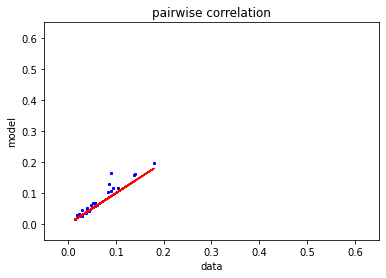

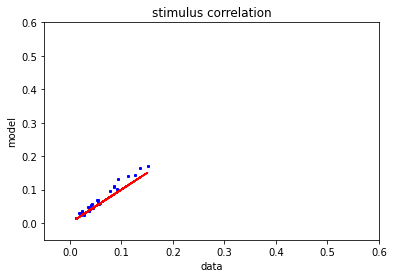

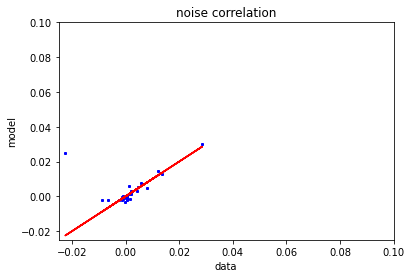

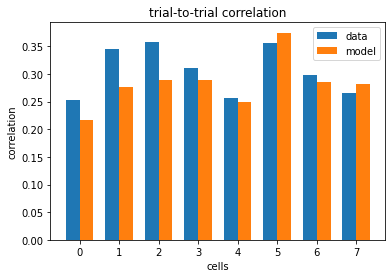

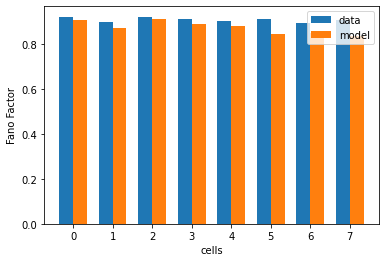

0.0003043134922063676


In [8]:
binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
t_list = [3, 3, 4, 4, 3, 4, 3, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 112, [1., 0., 0., 0.], seed=21)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=2, threshold=0.4, intv=0.3, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=21, thre=2)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial, [39, 60])
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

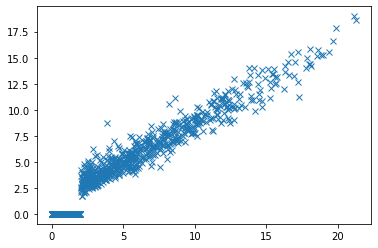

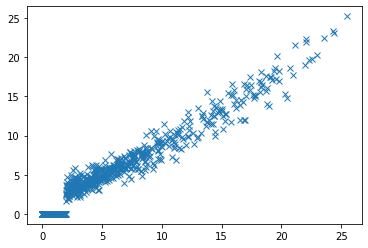

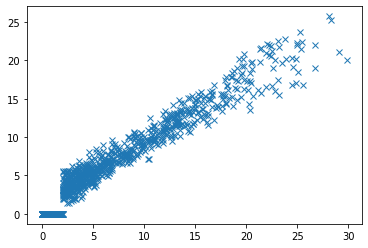

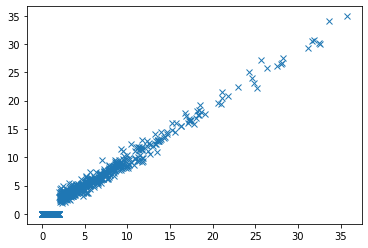

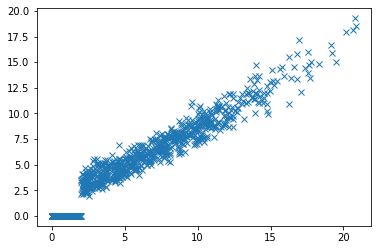

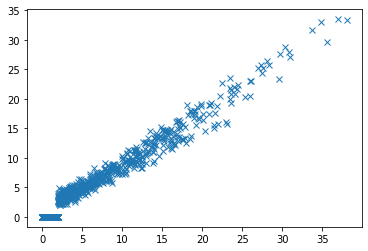

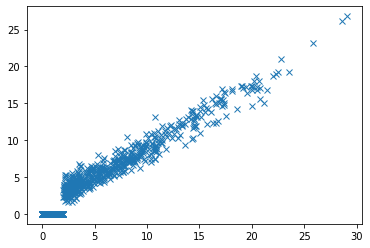

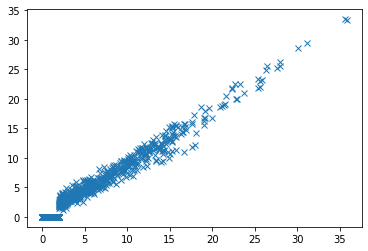

In [13]:
for cell in range(8):
    plt.plot(pred[:, cell], pred_single_trial_pre.mean(0)[:, cell], 'x')
    plt.show()